In [27]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt



In [2]:
# Get paths of ftse100 stocks data
data_dir = './data_stocks/ftse100/'
stocks_csv_files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith('.L.csv')]
companies_df = pd.read_csv('./data_symbols/lse_codes_companies.csv', usecols=[0, 1])

# read barclays data for testing
barc_df = pd.read_csv('./data_stocks/ftse100/BARC.L.csv')

In [3]:
def file_to_symbol(file):
    """Takes a filepath and returns the symbol"""
    return file.rsplit('/', 1)[1].rsplit('.', 1)[0]

In [4]:
def get_data(code):
    return pd.read_csv(data_dir + '/' + code + '.csv')

In [5]:
def highest_close_price(df):
    return df.loc[df['Close'].idxmax(), 'Close']
highest_close_price(barc_df)

296.5

In [6]:
def highest_close_date(df):
    return df.loc[df['Close'].idxmax(), 'Date']
highest_close_date(barc_df)

'2014-01-15'

In [7]:
def latest_close_price(df):
    return df.loc[df.index[-1], 'Close']
latest_close_price(barc_df)

161.44000244140625

In [8]:
def latest_close_date(df):
    return df.loc[df.index[-1], 'Date']
latest_close_date(barc_df)

'2019-04-09'

In [9]:
def highest_current_percentage_diff(df):
    """
    Returns the percentage (2 d.p.) difference between
    the highest and current closing price
    """
    highest_close = df.loc[df['Close'].idxmax(), 'Close']
    current_close = df.loc[df.index[-1], 'Close']
    return round((current_close - highest_close) / current_close, 2) * 100

highest_current_percentage_diff(barc_df)

-84.0

In [10]:
# Percentage difference between highest close and current close for all stocks
def percentage_diff_df(stocks_csv_files):
    result = []
    for file in stocks_csv_files:
        df = pd.read_csv(file)
        percentage = highest_current_percentage_diff(df)
        code = file.rsplit('/')[-1].replace('.csv', '')
        result.append((percentage, code))
    agg_df = (
        pd.DataFrame(result, columns=['percentage', 'code'])
        .sort_values(by='percentage', ascending=True)
    )
    return agg_df

agg_df = percentage_diff_df(stocks_csv_files)
agg_df.head()

,percentage,code
37,-215.0,CNA.L
40,-153.0,TUI.L
5,-134.0,FRES.L
89,-123.0,BT-A.L
88,-121.0,WPP.L


In [11]:
# Merge company names
if 'company' not in agg_df.columns:
    agg_df = pd.merge(agg_df, companies_df, on='code', how='left', validate='one_to_one')
agg_df.head()

,percentage,code,Company
0,-215.0,CNA.L,Centrica plc
1,-153.0,TUI.L,TUI AG
2,-134.0,FRES.L,Fresnillo PLC
3,-123.0,BT-A.L,BT Group plc
4,-121.0,WPP.L,WPP plc


In [12]:
# # Export agg_df to csv file
# agg_df.to_csv('./data_aggregated/highest_close_percentage_difference.csv')

In [13]:
def add_moving_average(df, days, name=''):
    column = name  if name else 'ma_{}'.format(days)
    df[column] = df['Close'].rolling(window=days).mean()
    return df

In [14]:
def add_ma_position(df, ma_1=50, ma_2=200):
    """
    Creates a new column 'ma_position' with possible
    values -1, +1.
    -1 when shorter SMA is below longer SMA
    +1 when shorter SMA is above longer SMA
    """
    column = 'ma_position'
    ma_1_df = df['Close'].rolling(window=ma_1).mean()
    ma_2_df = df['Close'].rolling(window=ma_2).mean()
    df[column] = np.where(ma_1_df > ma_2_df, 1, -1)
    return df

In [15]:
def add_ma_crossover(df, ma_1=50, ma_2=200, close_column='Close'):
    """
    Takes stock data and adds a column 'ma_crossover'
    which is 1 on the day where two moving averages cross over. 
    """
    column = 'ma_crossover'
    
    # Get moving averages
    ma_1_df = df['Close'].rolling(window=ma_1).mean()
    ma_2_df = df['Close'].rolling(window=ma_2).mean()

    # MA_1 below MA_2 >>> -1, MA_1 above MA_2 >>> +1
    position = pd.Series(np.where(ma_1_df > ma_2_df, 1, -1))
    
    # 1 if there is a change in position, otherwise 0
    df[column] = np.where(position != position.shift(1).fillna(method='bfill'), 1, 0)
    
    return df

def ma_crossover_dates(df):
    df = add_ma_crossover(df)
    return df[df['ma_crossover'] == 1]

In [16]:
def get_dfs(csv_files):
    """
    Returns a dict {symbol: df} where df is the dataframe
    of csv file.
    """
    return {file_to_symbol(file):pd.read_csv(file) for file in csv_files}

In [22]:
# Name of stock and dates of moving average crossover
def get_crossovers_df(stocks_csv_files):
    """
    Loop over all csv files containing stock data
    and return a dataframe on days where crossover
    took place.
    """
    crossover_df = pd.DataFrame()
    for symbol, df in get_dfs(stocks_csv_files).items():
        df = add_ma_crossover(df)
        df = add_ma_position(df)
        df = df[(df['ma_crossover'] == 1) & (df['ma_position'] == 1)].copy()
        df['symbol'] = symbol
        crossover_df = pd.concat([crossover_df, df])
    return crossover_df

crossover_df = get_crossovers_df(stocks_csv_files)
crossover_df.sort_values(by='Date').tail(10)

,Date,High,Low,Open,Close,Volume,Adj Close,ma_crossover,ma_position,symbol
1328,2019-04-03,1191.500000,1163.500000,1191.500000,1166.000000,5333428.0,1166.000000,1,1,SSE.L
1331,2019-04-05,1600.199951,1586.800049,1590.800049,1594.000000,7381505.0,1594.000000,1,1,GSK.L
1330,2019-04-05,238.199997,234.300003,235.600006,236.899994,29740722.0,236.899994,1,1,TSCO.L
1330,2019-04-05,927.599976,903.400024,903.400024,926.799988,9095081.0,926.799988,1,1,RR.L
1332,2019-04-08,334.899994,330.899994,333.000000,331.000000,29957467.0,331.000000,1,1,GLEN.L
1332,2019-04-09,4420.000000,4370.500000,4400.000000,4418.500000,1467822.0,4418.500000,1,1,ULVR.L
1332,2019-04-09,1039.500000,1028.500000,1035.500000,1028.500000,2900535.0,1028.500000,1,1,III.L
1328,2019-04-09,531.000000,526.531006,528.500000,529.000000,2310512.0,529.000000,1,1,SMT.L
1333,2019-04-09,580.799988,572.299988,576.099976,574.000000,27664307.0,574.000000,1,1,BP.L
1333,2019-04-09,2493.000000,2458.000000,2492.000000,2482.000000,1404649.0,2482.000000,1,1,CRH.L


In [18]:
# crossover_df.sort_values(by='Date').to_csv('./data_aggregated/moving_average_crossovers.csv')

In [23]:
crossover_df.sort_values(by='Date').tail(10)

,Date,High,Low,Open,Close,Volume,Adj Close,ma_crossover,ma_position,symbol
1328,2019-04-03,1191.500000,1163.500000,1191.500000,1166.000000,5333428.0,1166.000000,1,1,SSE.L
1331,2019-04-05,1600.199951,1586.800049,1590.800049,1594.000000,7381505.0,1594.000000,1,1,GSK.L
1330,2019-04-05,238.199997,234.300003,235.600006,236.899994,29740722.0,236.899994,1,1,TSCO.L
1330,2019-04-05,927.599976,903.400024,903.400024,926.799988,9095081.0,926.799988,1,1,RR.L
1332,2019-04-08,334.899994,330.899994,333.000000,331.000000,29957467.0,331.000000,1,1,GLEN.L
1332,2019-04-09,4420.000000,4370.500000,4400.000000,4418.500000,1467822.0,4418.500000,1,1,ULVR.L
1332,2019-04-09,1039.500000,1028.500000,1035.500000,1028.500000,2900535.0,1028.500000,1,1,III.L
1328,2019-04-09,531.000000,526.531006,528.500000,529.000000,2310512.0,529.000000,1,1,SMT.L
1333,2019-04-09,580.799988,572.299988,576.099976,574.000000,27664307.0,574.000000,1,1,BP.L
1333,2019-04-09,2493.000000,2458.000000,2492.000000,2482.000000,1404649.0,2482.000000,1,1,CRH.L


## Largest Gap Strategy

#### Largest gap between long term moving average and very short term moving average

Long term MA = 200 days<br>
Short term MA = 5 days

There is bound to be a pull back or short term price reversal when the gap between MA 200 and MA 5 is large.

Strategy is to itterate through all stocks and find the ones with the largest gap between the two moving averages.

The gap needs to be in percentage, so that we can compare the gap between different stocks.<br>
Example:

    symbol: LLOY.L
    date: 28/12/2018
    MA 200 = 61.01 
    MA 5 = 50.94
    gap = 16.5%
    calculation: (61.01 - 50.94)/61.01

In [20]:
def strategy_largest_gap():
    """
    Psuedo code:
        for each stock:
            - Get 200 day mean
            - Get 5 day mean
            - Calculate difference
            - Calculate difference in percent relative to 200 day mean
        return df with all stocks current percent difference.
    """
    result = pd.DataFrame()
    for symbol, df in get_dfs(stocks_csv_files).items():
        mean_200, mean_5 = df.iloc[-200:]['Close'].mean(), df.iloc[-5:]['Close'].mean()
        means_diff_percent = ((mean_200 - mean_5) / mean_200) * 100
        
        # Skip the stocks whose mean percentage diference is negative
        if means_diff_percent < 0:
            continue
            
        df = df.iloc[-1:].copy()
        df['symbol'] = symbol
        df['means_diff_percent'] = means_diff_percent
        result = pd.concat([result, df])
    
    result = result.sort_values(by='means_diff_percent')
    return result

strategy_largest_gap()

,Date,High,Low,Open,Close,Volume,Adj Close,symbol,means_diff_percent
1333,2019-04-09,2538.500000,2496.156982,2518.000000,2502.500000,3094410.0,2502.500000,RDSB.L,0.054613
1333,2019-04-09,5022.000000,4966.000000,5022.000000,4977.000000,451031.0,4977.000000,ITRK.L,0.145688
1328,2019-04-09,284.380005,208.850006,280.600006,280.600006,6329208.0,280.600006,SLA.L,0.268689
1332,2019-04-09,907.400024,897.599976,905.599976,898.799988,3171305.0,898.799988,RR.L,0.698610
1333,2019-04-09,659.750000,650.000000,651.500000,655.299988,17119917.0,655.299988,HSBA.L,1.088691
1333,2019-04-09,1565.000000,1545.000000,1549.000000,1565.000000,641020.0,1565.000000,HSX.L,1.601927
1332,2019-04-09,282.899994,277.530304,280.700012,278.399994,3695729.0,278.399994,MKS.L,1.870310
1333,2019-04-09,2018.000000,1995.500000,2001.000000,1995.500000,1127173.0,1995.500000,AHT.L,1.981480
1332,2019-04-09,249.399994,244.600006,245.600006,246.100006,4017352.0,246.100006,KGF.L,2.070221
1332,2019-04-09,1154.500000,1143.000000,1152.000000,1146.000000,2058704.0,1146.000000,SSE.L,2.351614


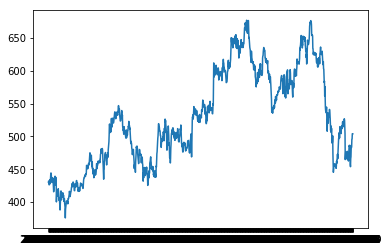

In [21]:
plt.figure()
BA = pd.read_csv('./data_stocks/ftse100/BA.L.csv')
plt.plot(BA['Date'], BA['Close'])
plt.show()